Using device: cuda
### 데이터 로딩 및 전처리 ###

### 예측 문제 셋팅 ###
스케일링 완료된 데이터 Shape: (3654, 7)

### 시퀀스 데이터 생성 ###
생성된 입력 시퀀스 Shape: (1824, 4, 7) (num_sequences, window_in, input_dim)
생성된 출력 시퀀스 Shape: (1824, 3) (num_sequences, window_out)

### Train, Validation, Test set 분할 (시간 순서 기준, Test 400개 고정) ###
Train set Shape: (854, 4, 7), (854, 3)
Validation set Shape: (570, 4, 7), (570, 3)
Test set Shape: (400, 4, 7), (400, 3)

### PyTorch DataLoader 준비 ###
Train_Loader 배치 개수: 7
Val_Loader 배치 개수: 5
Test_Loader 배치 개수: 4

### LSTM 모델 정의 및 학습 ###
LSTM 모델 학습 시작 (300 에폭)...
Epoch 1/300: Train Loss = 178.4410, Val Loss = 170.6113
Epoch 2/300: Train Loss = 171.0616, Val Loss = 159.4032
Epoch 3/300: Train Loss = 155.6476, Val Loss = 139.1808
Epoch 4/300: Train Loss = 133.9581, Val Loss = 118.9098
Epoch 5/300: Train Loss = 115.3763, Val Loss = 104.6153
Epoch 6/300: Train Loss = 102.2157, Val Loss = 94.4175
Epoch 7/300: Train Loss = 92.6973, Val Loss = 86.3522
Epoch 8/300: Train Loss = 84.9286, Val Loss = 7

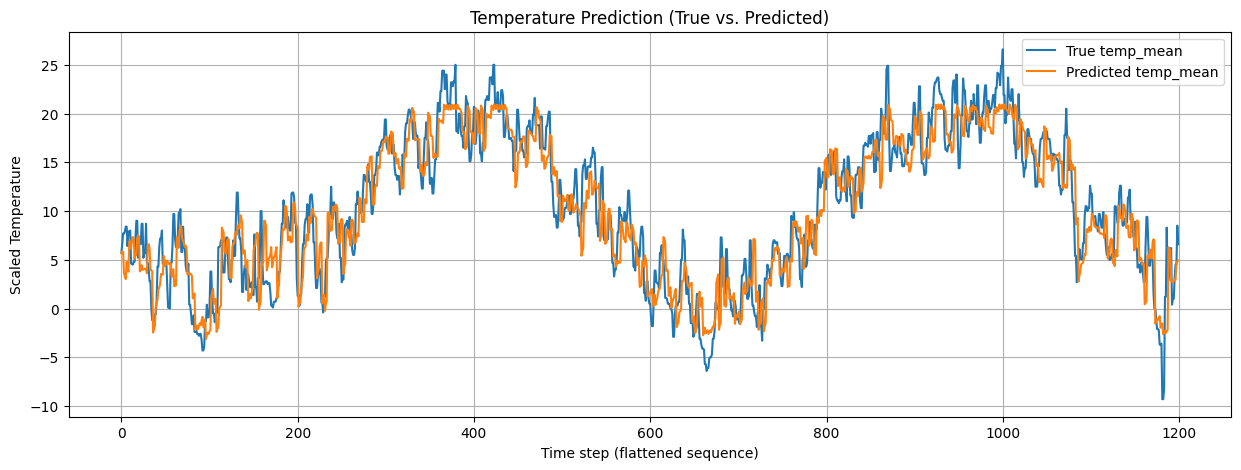


### 특정 시퀀스 예측 상세 시각화 (첫 5개) ###


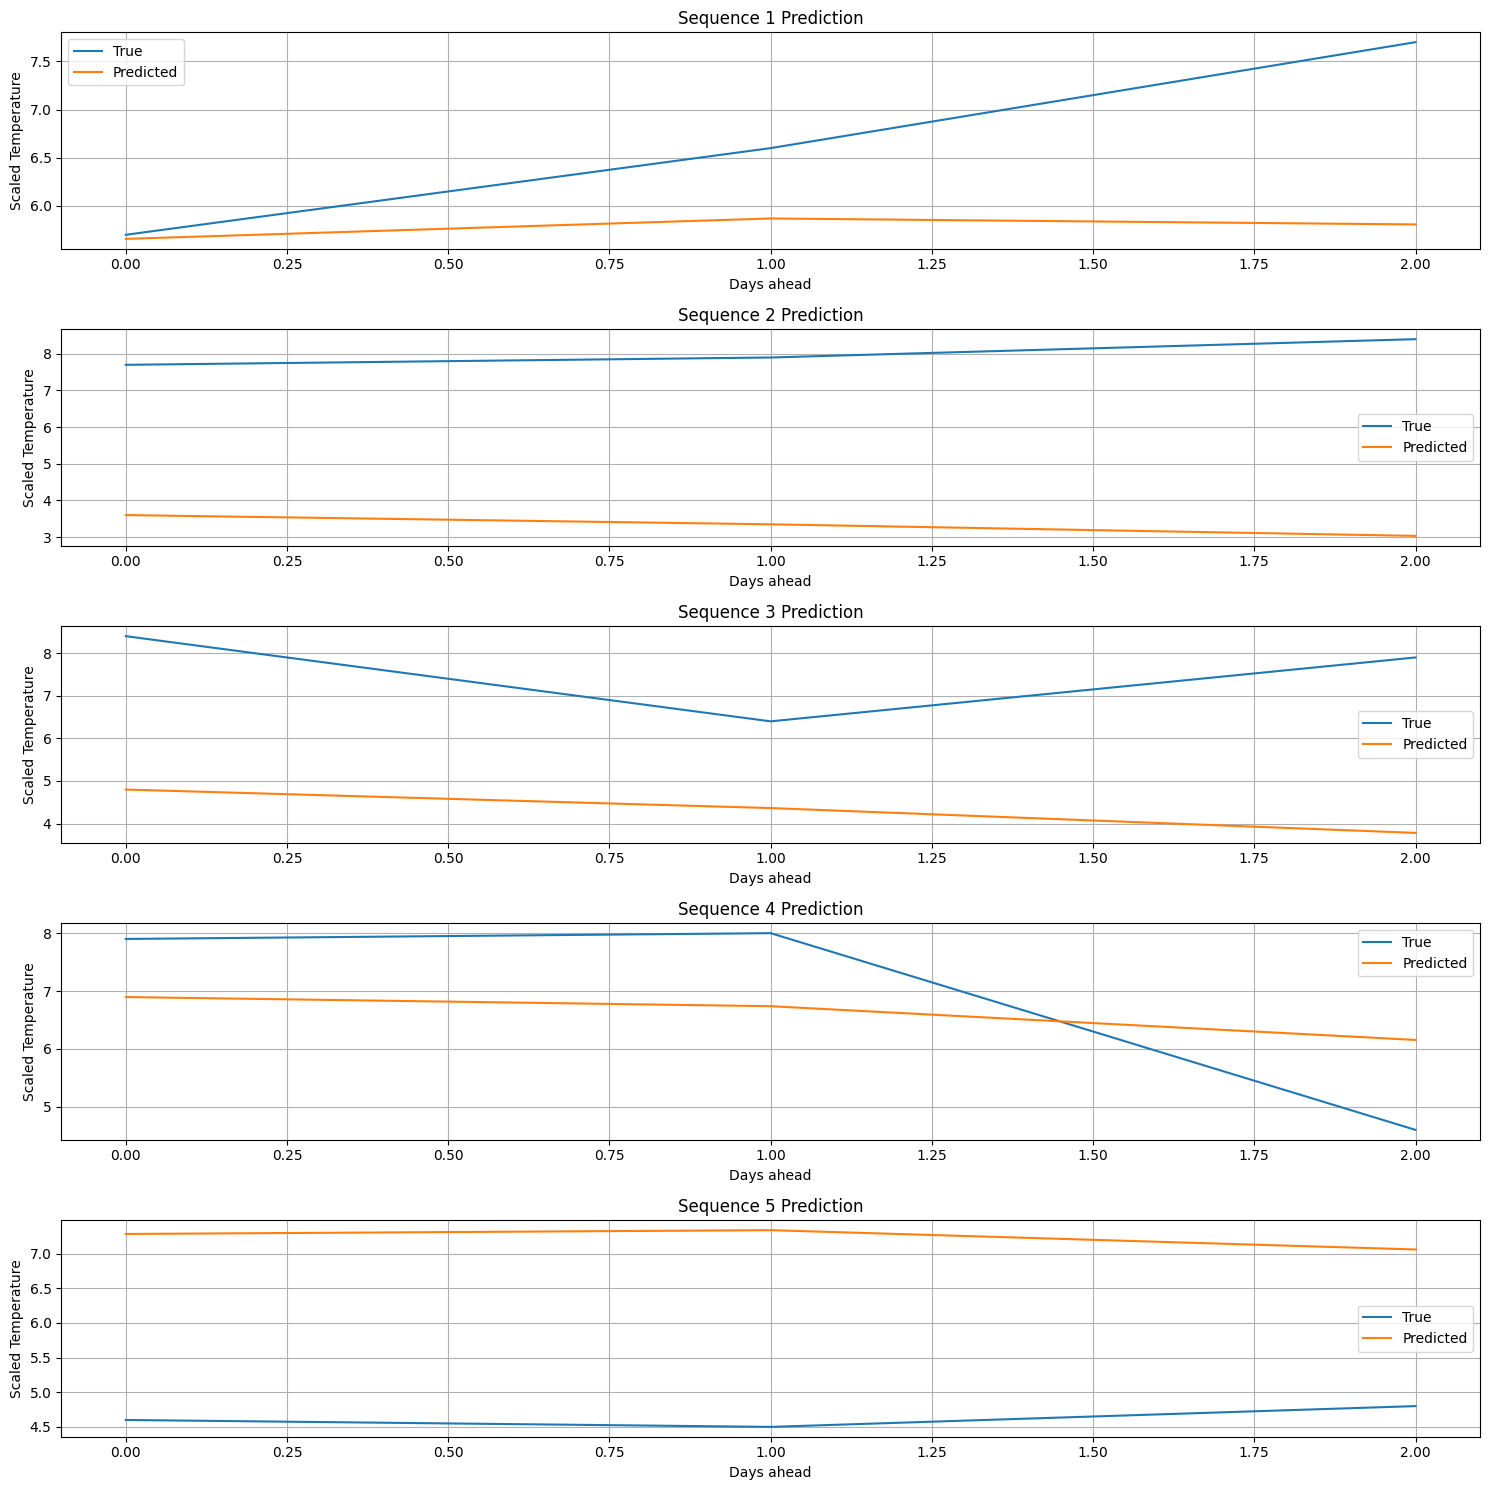

In [2]:
#%%
#기본 모듈 로드 (numpy, pandas)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#sklearn 모듈 로드
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # MSE 계산을 위해 명시적으로 임포트
#신경망 학습을 위한 scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 시드 설정 (재현성 확보)
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("### 데이터 로딩 및 전처리 ###")
#%%
# 기초데이터 불러오기
# 파일 경로는 실제 파일 위치에 맞게 수정해주세요.
try:
    X = pd.read_csv('../BASEL_X.csv')
    Y = pd.read_csv('../BASEL_Y.csv') # Y는 예측 문제에서는 사용하지 않음
except FileNotFoundError:
    print("CSV 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    exit()

# 데이터 시간 순 정렬 (시계열 처리에 필수)
X['DATE'] = pd.to_datetime(X['DATE'])
X = X.sort_values(by='DATE').reset_index(drop=True)

#%%
print("\n### 예측 문제 셋팅 ###")
# 예측 문제 셋팅 : 이전 n일간의 날씨로 다음 m일간의 특정 특징 값 예측
# temp_min, temp_max는 삭제
# 예측 대상: BASEL_temp_mean (인덱스 6)

X_pre = X.drop(columns=['DATE','MONTH','BASEL_temp_min','BASEL_temp_max'])
X_pre.columns = [x.replace('BASEL_','') for x in X_pre.columns]

# 스케일링 (시계열 데이터 전체에 대해 수행)
# MinMaxScaler는 0-1 범위로 스케일링하여 RNN/LSTM 학습에 안정적
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_pre)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_pre.columns) # 스케일링된 데이터로 DataFrame 재생성
X_scaled_df = X_pre.copy()
print(f"스케일링 완료된 데이터 Shape: {X_scaled_df.shape}")

#%%
print("\n### 시퀀스 데이터 생성 ###")
# 시계열 시퀀스 (window) 생성
# 이전 window_in 길이로 다음 window_out 길이 예측

window_in = 4 # 입력 시퀀스 길이 (이전 4일)
window_out = 3 # 예측 시퀀스 길이 (다음 3일)
stride = 2 # 시퀀스 생성 시 이동 간격

X_ts, Y_ts = [], []
# 슬라이딩 윈도우 적용
for start in range(0, len(X_scaled_df) - window_in - window_out + 1, stride):
    end_input = start + window_in
    end_output = end_input + window_out

    # 입력 시퀀스: start 부터 end_input 까지의 모든 특징
    x_seq = X_scaled_df.iloc[start : end_input, :].values
    # 출력 시퀀스: end_input 부터 end_output 까지의 'temp_mean' 값
    y_seq = X_scaled_df.iloc[end_input : end_output, X_scaled_df.columns.get_loc('temp_mean')].values # temp_mean 컬럼 인덱스 직접 가져오기

    X_ts.append(x_seq)
    Y_ts.append(y_seq)

X_ts_np = np.array(X_ts)
Y_ts_np = np.array(Y_ts)

print(f"생성된 입력 시퀀스 Shape: {X_ts_np.shape} (num_sequences, window_in, input_dim)")
print(f"생성된 출력 시퀀스 Shape: {Y_ts_np.shape} (num_sequences, window_out)") # 예측 대상은 temp_mean 하나이므로 output_dim=1

#%%
print("\n### Train, Validation, Test set 분할 (시간 순서 기준, Test 400개 고정) ###")

total_sequences = X_ts_np.shape[0]

test_size = 400  # 테스트셋은 마지막 400개 고정
remaining_size = total_sequences - test_size  # train + validation 크기

# train : validation 비율 설정 (나머지 데이터에 대해)
train_ratio = 0.6  # 70%를 학습, 30%를 검증

train_size = int(remaining_size * train_ratio)
val_size = remaining_size - train_size

# 데이터 분할
X_train = X_ts_np[:train_size]
Y_train = Y_ts_np[:train_size]

X_val = X_ts_np[train_size:train_size + val_size]
Y_val = Y_ts_np[train_size:train_size + val_size]

X_test = X_ts_np[-test_size:]  # 마지막 400개
Y_test = Y_ts_np[-test_size:]

print(f"Train set Shape: {X_train.shape}, {Y_train.shape}")
print(f"Validation set Shape: {X_val.shape}, {Y_val.shape}")
print(f"Test set Shape: {X_test.shape}, {Y_test.shape}")


#%%
print("\n### PyTorch DataLoader 준비 ###")
# TensorDataset 및 DataLoader 생성
D_train = TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(Y_train).to(device))
D_val = TensorDataset(torch.Tensor(X_val).to(device), torch.Tensor(Y_val).to(device)) # 검증 데이터로더 추가
D_test = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))

Train_Loader = DataLoader(D_train, batch_size=128, shuffle=True, drop_last=False) # 학습 시 셔플
Val_Loader = DataLoader(D_val, batch_size=128, shuffle=False, drop_last=False) # 검증 시 셔플 안 함
Test_Loader = DataLoader(D_test, batch_size=128, shuffle=False, drop_last=False) # 테스트 시 셔플 안 함

print(f"Train_Loader 배치 개수: {len(Train_Loader)}")
print(f"Val_Loader 배치 개수: {len(Val_Loader)}")
print(f"Test_Loader 배치 개수: {len(Test_Loader)}")


#%%
print("\n### LSTM 모델 정의 및 학습 ###")

# 모델 파라미터 (하이퍼파라미터)
input_dim = X_train.shape[-1] # 입력 특징 차원
hidden_dim = 64 # RNN보다 Hidden 차원을 키워볼 수 있음
output_dim = window_out # 예측할 미래 스텝 수 (3일)
num_layers = 2 # 레이어 수

# >>> RNN 대신 LSTM 모델 사용 <<<
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM 레이어 정의 (batch_first=True)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # 마지막 LSTM 출력을 예측할 output_dim 차원으로 매핑하는 선형 레이어
        # LSTM 출력은 (batch_size, seq_length, hidden_dim) 이므로,
        # 시퀀스의 마지막 스텝 ([ : , -1 , : ]) 출력을 선형 레이어의 입력으로 사용
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim)

        # LSTM 순전파
        # out shape: (batch_size, seq_length, hidden_dim)
        # hidden shape: (h_n, c_n) where h_n, c_n shape: (num_layers, batch_size, hidden_dim)
        out, _ = self.lstm(x)

        # 시퀀스의 마지막 스텝의 hidden state를 가져와 fc 레이어에 입력
        # out[:, -1, :] shape: (batch_size, hidden_dim)
        out = self.fc(out[:, -1, :]) # RNN과 동일하게 마지막 스텝 출력 사용

        # out shape: (batch_size, output_dim)

        return out

# 모델, 손실 함수, 옵티마이저 정의
lstm_model = LSTMPredictor(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss() # 예측 문제이므로 MSE 사용
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3) # Adam 옵티마이저

# 학습 파라미터
num_epochs = 300 # 에폭 수를 늘려볼 수 있음
# 조기 종료 (Early Stopping)를 위한 변수
best_val_loss = float('inf')
patience = 20 # 검증 손실 개선이 없을 때 기다릴 에폭 수
epochs_no_improve = 0


print(f"LSTM 모델 학습 시작 ({num_epochs} 에폭)...")
# 학습 루프
for epoch in range(num_epochs):
    lstm_model.train()
    total_train_loss = 0

    # 학습 데이터 순전파 및 역전파
    for batch_x, batch_y in Train_Loader:
        # batch_x shape: (batch_size, window_in, input_dim)
        # batch_y shape: (batch_size, window_out)

        optimizer.zero_grad() # 옵티마이저 초기화

        prediction = lstm_model(batch_x) # 모델 순전파
        loss = criterion(prediction, batch_y) # 손실 계산

        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

        total_train_loss += loss.item() * batch_x.size(0) # 배치 사이즈 고려 합산

    # 학습 데이터 평균 손실 계산
    avg_train_loss = total_train_loss / len(Train_Loader.dataset)

    # 검증 데이터로 모델 평가
    lstm_model.eval() # 평가 모드
    total_val_loss = 0
    with torch.no_grad(): # 그래디언트 계산 비활성화
        for batch_x_val, batch_y_val in Val_Loader:
            prediction_val = lstm_model(batch_x_val)
            val_loss = criterion(prediction_val, batch_y_val)
            total_val_loss += val_loss.item() * batch_x_val.size(0)

    # 검증 데이터 평균 손실 계산
    avg_val_loss = total_val_loss / len(Val_Loader.dataset)

    # 에폭별 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # 조기 종료 체크
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # 필요하다면 모델 가중치 저장: torch.save(lstm_model.state_dict(), 'best_lstm_predictor.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"조기 종료! 검증 손실이 {patience} 에폭 동안 개선되지 않았습니다.")
            break # 학습 루프 중단

print("LSTM 모델 학습 완료.")

#%%
print("\n### 학습된 모델로 테스트셋 예측 및 평가 ###")

lstm_model.eval() # 평가 모드
prediction = []
ground_truth = []
test_losses = [] # 테스트 시퀀스별 MSE 저장

with torch.no_grad(): # 그래디언트 계산 비활성화
    for batch_x, batch_y in Test_Loader:
        # batch_x shape: (batch_size, window_in, input_dim)
        # batch_y shape: (batch_size, window_out)

        output = lstm_model(batch_x) # 예측 수행

        # 예측 결과와 실제 값 저장
        prediction.append(output.cpu().numpy())
        ground_truth.append(batch_y.cpu().numpy())

        # 시퀀스별 MSE 계산
        # criterion(output, batch_y, reduction='none') 사용 시 (batch_size, window_out) 형태 반환
        # 각 시퀀스(batch)의 MSE 평균을 구함
        batch_mse = torch.mean((output - batch_y)**2, dim=1) # (batch_size,) 형태
        test_losses.append(batch_mse.cpu().numpy())


prediction = np.concatenate(prediction)
ground_truth = np.concatenate(ground_truth)
test_losses = np.concatenate(test_losses) # 각 테스트 시퀀스에 대한 MSE 값 배열


# 테스트셋 전체 평균 MSE 계산
overall_test_mse = np.mean(test_losses)

print(f"테스트셋 평균 MSE: {overall_test_mse:.4f}")

#%%
print("\n### 예측 결과 시각화 ###")
# 전체 시퀀스를 평탄화하여 시각화
plt.figure(figsize=(15, 5))
plt.plot(ground_truth.ravel(), label="True temp_mean") # ravel()로 평탄화
plt.plot(prediction.ravel(), label="Predicted temp_mean") # ravel()로 평탄화
plt.title("Temperature Prediction (True vs. Predicted)")
plt.xlabel("Time step (flattened sequence)")
plt.ylabel("Scaled Temperature")
plt.legend()
plt.grid(True)
plt.show()

# 특정 시퀀스만 시각화하여 예측 결과 상세 확인
# 예시: 테스트셋의 첫 5개 시퀀스 확인
print("\n### 특정 시퀀스 예측 상세 시각화 (첫 5개) ###")
num_sequences_to_plot = min(5, len(X_test)) # 테스트셋 크기 고려
plt.figure(figsize=(15, num_sequences_to_plot * 3))

for i in range(num_sequences_to_plot):
    plt.subplot(num_sequences_to_plot, 1, i + 1)
    # 예측 시퀀스 시간 축 (0, 1, 2)
    time_steps = np.arange(window_out)
    plt.plot(time_steps, ground_truth[i], label="True")
    plt.plot(time_steps, prediction[i], label="Predicted")
    plt.title(f"Sequence {i+1} Prediction")
    plt.xlabel("Days ahead")
    plt.ylabel("Scaled Temperature")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# %%

